<a href="https://colab.research.google.com/github/mikelabadie/Earnings_Call_Transcripts/blob/master/analysis_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing: Tools

In [0]:
! pip install pyLDAvis

from IPython.display import clear_output

import numpy as np
import nltk
nltk.download('wordnet')

import spacy
spacynlp = spacy.load('en_core_web_sm')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import string
exclude = set(string.punctuation)

from nltk.stem.wordnet import WordNetLemmatizer

lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    stop_free = stop_free.replace("-", " ")
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized 
  
clear_output()

## Preprocessing: Bring in Data


In [0]:
data_directory = "/content/gdrive/My Drive/DATS6450 - Labadie - Data/"

#### Read Call Pickle and Build Meta-data and Text DataFrames

In [3]:
# import the call dataset
import pandas as pd
import numpy as np
import pickle
import os

from google.colab import drive
drive.mount('/content/gdrive')

if os.path.exists(data_directory+"ProcessedCallsPickleUpdated_v2"):
    pfile = open(data_directory+"ProcessedCallsPickleUpdated_v2", "rb")
    calls = pickle.load(pfile)                 
    pfile.close()
    
df_metadata = calls["metadata"]
df_text = calls["text"]
  
clear_output()

print("Metadata Shape:",df_metadata.shape, "Text Shape:",df_text.shape)

Metadata Shape: (5101, 6) Text Shape: (640132, 11)


#### List of Companies and Industries/Sectors

In [4]:
company_list = pd.read_csv(data_directory+"companylist.csv")
company_list.shape

(5285, 9)

#### Tickers -> CIK:  Used to connect to financial statements from SEC

In [5]:
cik_ticker_map = pd.read_csv(data_directory+"cik_ticker.csv",sep="|",dtype={"CIK":object})
cik_ticker_map.shape

(13737, 8)

#### Financial Statement Data

In [0]:
#%%
directory=data_directory+"2018q4/"
filename = directory + "sub.txt"

df_sub = pd.read_table(filename,dtype={"cik":object})
df_sub=df_sub.merge(cik_ticker_map,left_on=["cik"],right_on=["CIK"],how="left")

filename = directory + "tag.txt"
df_tag = pd.read_table(filename)

filename = directory + "pre.txt"
df_pre = pd.read_table(filename)

filename = directory + "num.txt"
df_num = pd.read_table(filename)

df_fin_stmt = df_sub.merge(df_pre).merge(df_num).merge(df_tag)
df_fin_stmt_items = df_fin_stmt[df_fin_stmt["stmt"]=="IS"][["Ticker","line","plabel","tlabel"]].drop_duplicates()

## Preprocessing: Create a List of Tickers to Analyze

In [7]:
industry="Industrial Machinery/Components"
ticker_list = list(company_list[(company_list["Industry"]==industry)]["Symbol"])

calls_to_use = df_metadata[(df_metadata["ticker"].isin(ticker_list))].sort_values(by=["ticker"])
print("Number of Calls:",calls_to_use.shape[0])

Number of Calls: 183


## Topic Modeling:  Analyze Paragraphs using Financial Statements

#### Functions to Plot Heatmap and Get the Line Items from Financial Statements for a Ticker

In [0]:
import seaborn as sns

def make_heatmap(results):
    inc_lines_in_call = results.sum().sort_values()
    inc_lines_in_call = inc_lines_in_call[inc_lines_in_call > 0].index.values

    if inc_lines_in_call.any():
        sns.heatmap(results[inc_lines_in_call].T)
    else:
        sns.heatmap(results.T)
    
    plt.show()
    
def get_inc_stmt_lines(ticker):
    items_to_find = df_fin_stmt_items[df_fin_stmt_items["Ticker"]==ticker]
    net_inc = items_to_find[items_to_find["plabel"].str.match("[N|n]et.*[I|i]ncome")]["line"].min()
    items_to_find = items_to_find[items_to_find["line"]<=net_inc]
    items_to_find = list(items_to_find["plabel"])+list(items_to_find["tlabel"])

    items_to_find = [item.lower().replace(",","") for item in items_to_find]
    items_to_find += [item.replace("profit","margin") for item in items_to_find if "profit" in item]
    #items_to_find += ["of sales","of revenues","of revenue"]
    #items_to_find += [item.replace("net ","") for item in items_to_find if "net" in item]
    
    return list(np.unique(items_to_find))

#### Perform Cleaning of a Paragraph Based on Financial "Lingo"

In [0]:
def clean_paragraph(paragraph):
    paragraph = paragraph.replace(" of revenue"," ").replace(" of revenues"," ").replace(" of sales"," ")
    return paragraph

#### Analyze Usage of Terms from Financial Statements on Earnings Calls

https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx


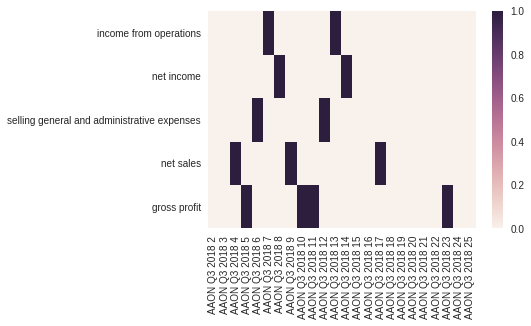


https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


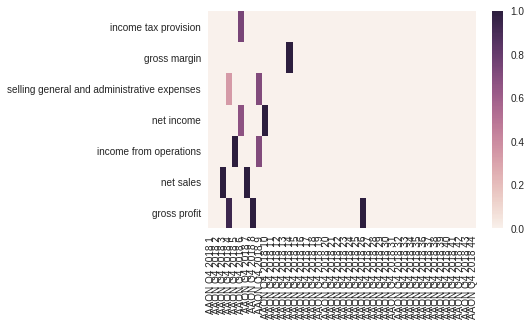


https://www.fool.com/earnings/call-transcripts/2019/02/28/acacia-mining-aca-q4-2018-earnings-conference-call.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/08/axcelis-technologies-acls-q4-2018-earnings-confere.aspx


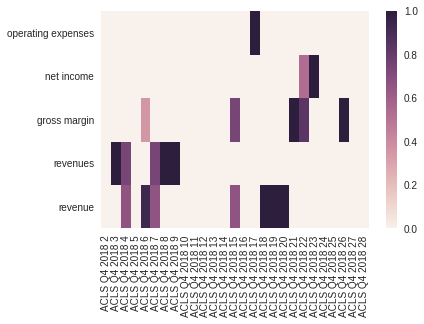


https://www.fool.com/earnings/call-transcripts/2018/11/01/axcelis-technologies-inc-acls-q3-2018-earnings-con.aspx


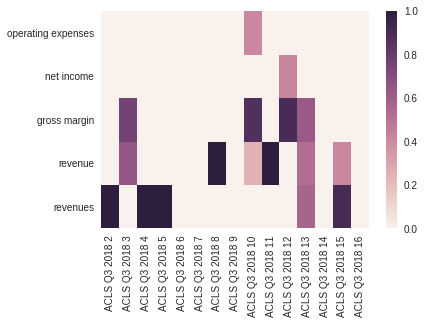


https://www.fool.com/earnings/call-transcripts/2019/02/05/advanced-energy-industries-aeis-q4-2018-earnings-c.aspx


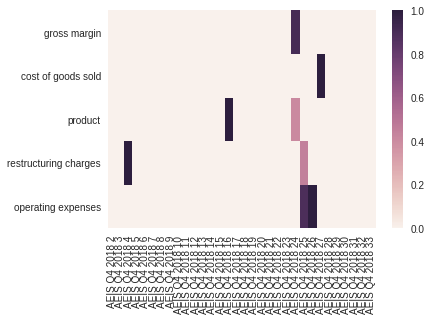


https://www.fool.com/earnings/call-transcripts/2019/02/06/agco-agco-q4-2018-earnings-conference-call-transcr.aspx


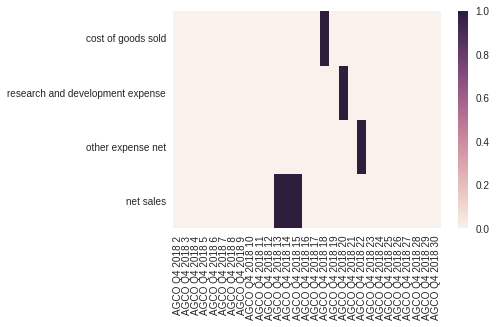


https://www.fool.com/earnings/call-transcripts/2019/02/21/altra-industrial-motion-corp-aimc-q4-2018-earnings.aspx


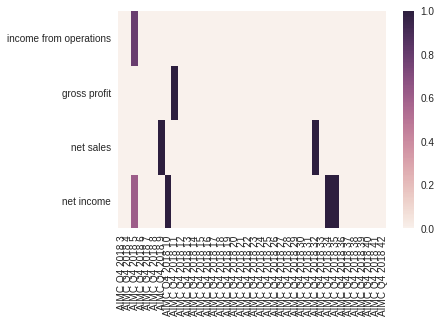


https://www.fool.com/earnings/call-transcripts/2018/10/26/altra-holdings-aimc-q3-2018-earnings-conference-ca.aspx


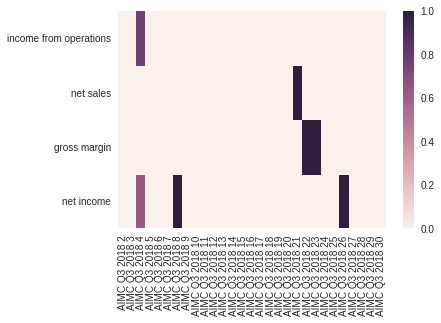


https://www.fool.com/earnings/call-transcripts/2018/11/01/alamo-group-inc-alg-q3-2018-earnings-conference-ca.aspx


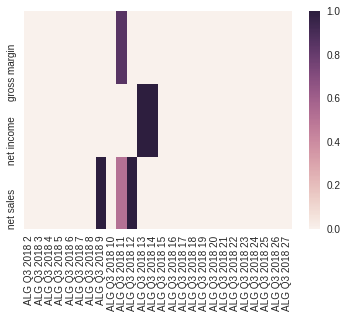


https://www.fool.com/earnings/call-transcripts/2019/03/01/alamo-group-alg-q4-2018-earnings-conference-call-t.aspx


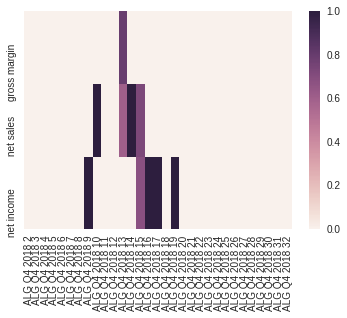


https://www.fool.com/earnings/call-transcripts/2019/02/19/apergy-corp-apy-q4-2018-earnings-conference-call-t.aspx
https://www.fool.com/earnings/call-transcripts/2018/10/31/apergy-corporation-apy-q3-2018-earnings-conference.aspx
https://www.fool.com/earnings/call-transcripts/2018/11/27/evoqua-water-technologies-corp-aqua-q4-2018-earnin.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/06/atkore-international-group-inc-atkr-q1-2019-earnin.aspx
https://www.fool.com/earnings/call-transcripts/2018/11/28/atkore-international-group-inc-atkr-q4-2018-earnin.aspx
https://www.fool.com/earnings/call-transcripts/2018/09/26/actuant-corporation-atu-q4-2018-earnings-conferenc.aspx
https://www.fool.com/earnings/call-transcripts/2018/06/20/actuant-corporation-atu-q3-2018-earnings-conferenc.aspx
https://www.fool.com/earnings/call-transcripts/2019/02/01/brunswick-bc-q4-2018-earnings-conference-call-tran.aspx
https://www.fool.com/earnings/call-transcripts/2018/10/26/brunswick-corp-bc-q3-2018-ear

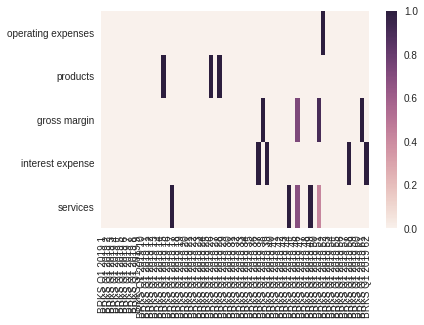

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

num_calls = 25
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row.name)
    prepared_remarks = df_text[(df_text["Call Section"]=="Prepared Remarks")&
                               (df_text["Speaker"]!="Operator")&
                               (df_text["Link"]==row["Link"])]
    
    items_to_find = get_inc_stmt_lines(row["ticker"])
    #print(np.unique(items_to_find))

    if len(items_to_find) > 0:
        max_ngram = np.max([len(item.split()) for item in items_to_find])
        min_ngram = np.min([len(item.split()) for item in items_to_find])

        corpus = list(prepared_remarks["Text"])
        corpus = [clean_paragraph(paragraph) for paragraph in corpus]
        tfidf_vectorizer  = TfidfVectorizer(ngram_range=(min_ngram, max_ngram),vocabulary=items_to_find)
        tfidf = tfidf_vectorizer.fit_transform(corpus)

        results = pd.DataFrame(data=tfidf.toarray(), index=prepared_remarks.index.values, columns=tfidf_vectorizer.get_feature_names())
        make_heatmap(results)
        print()

## Topic Modeling:  Assign a Topic to Each Paragraph

#### Add to Stop Lists Based on Companies

In [0]:
removal_list = ["The","International","Incorporated","Inc","Corporation","Corp","Group","Holdings","Company","Co.","Brands",".",",","&"]
#removal_list += ["Restaurants","Restaurant","Stores","Store"]

def clean_company_name(name):
    for item in removal_list:
        name = name.replace(item,"")
    return name.strip()

company_stop_words = np.unique([clean_company_name(x) for x in calls_to_use["company"].values])

In [0]:
#[stop.add(x) for x in company_stop_words]

#### Build Corpus

In [13]:
corpus, named_ents, call_names, paragraph_nums, corpus_whole_calls, call_names_whole_calls = [], [], [], [], [], []

num_calls = 2
for _, row in calls_to_use[0:num_calls].iterrows():
    print(row["Link"])
    prepared_remarks = df_text[df_text["Link"]==row["Link"]]
    prepared_remarks = prepared_remarks[(prepared_remarks["Call Section"]=="Prepared Remarks")&(prepared_remarks["Speaker"]!="Operator")]
    
    #corpus += list(prepared_remarks["Cleaned Text"])
    cleaned_text_for_call = [clean(paragraph) for paragraph in prepared_remarks["Text"]]
    corpus += cleaned_text_for_call
    
    for paragraph in prepared_remarks["Text"]:
        ents = spacynlp(paragraph).ents
        named_ents.append([ent.text.replace("\n","").upper() for ent in ents])
    
    call_names += list(prepared_remarks.index)
    
    paragraph_nums  += list(prepared_remarks["Call Paragraph Num"])
    
    corpus_whole_calls.append(" ".join(cleaned_text_for_call))
    call_names_whole_calls.append(row["ticker"] + " " + row["period"])


https://www.fool.com/earnings/call-transcripts/2018/11/01/aaon-inc-aaon-q3-2018-earnings-conference-call-tra.aspx
https://www.fool.com/earnings/call-transcripts/2019/03/02/aaon-inc-aaon-q4-2018-earnings-conference-call-tra.aspx


#### Scikit Learn Topic Modeling

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [15]:
n_components = 25
n_top_words = 5

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf_vectorizer  = TfidfVectorizer(ngram_range=(1,1),min_df=0.001,max_df=0.25)
tfidf = tfidf_vectorizer .fit_transform(corpus)
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

W = nmf.fit_transform(tfidf)
df_topics = pd.DataFrame(W,index=call_names)

Topic #0: share per earnings diluted decreased
Topic #1: price increase backlog june weve
Topic #2: sga decrease expense increased percentage
Topic #3: tax rate effective decreased act
Topic #4: statement aaons looking forward including
Topic #5: 31 december increase net result
Topic #6: capital 31 balance december expenditure
Topic #7: gross profit quarter company compared
Topic #8: open question moderator ill that
Topic #9: lab believe exists anywhere ton
Topic #10: turn like detail discus id
Topic #11: young east debt deal day
Topic #12: september net 30 month mainly
Topic #13: market went 50 change commercial
Topic #14: another quarter one increase likewise
Topic #15: attractive customer upon 32 astoundingly
Topic #16: scheduled lab april utilization target
Topic #17: compounded aaon annual growth per
Topic #18: talk curve painstaking catching materialize
Topic #19: young woman instead appointed is
Topic #20: unit whats sold pace 115
Topic #21: this simultaneously senior stay clima

In [16]:
df_topics[4].sort_values(ascending=False).head(10)

AAON Q3 2018 2     1.177043
AAON Q4 2018 1     1.025454
AAON Q4 2018 2     0.519422
AAON Q4 2018 26    0.129147
AAON Q4 2018 7     0.000000
AAON Q4 2018 6     0.000000
AAON Q4 2018 5     0.000000
AAON Q4 2018 4     0.000000
AAON Q4 2018 3     0.000000
AAON Q4 2018 9     0.000000
Name: 4, dtype: float64

In [17]:
df_topics.loc["AAON Q4 2018 1",].sort_values(ascending=False).head(10)

4     1.025454
24    0.000000
11    0.000000
1     0.000000
2     0.000000
3     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
Name: AAON Q4 2018 1, dtype: float64

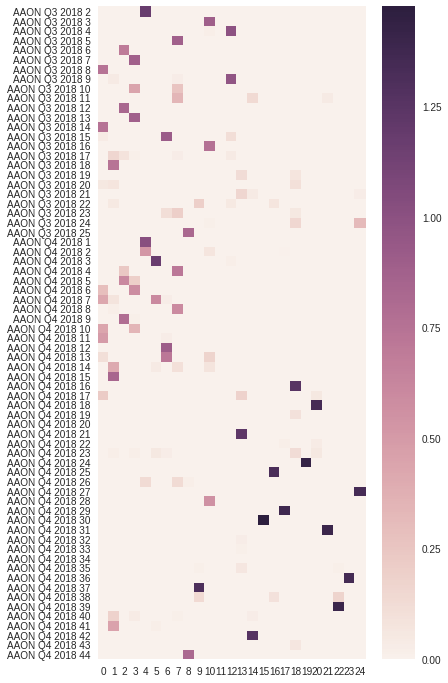

In [18]:
f,axs = plt.subplots(1,1,figsize=(6,12))
sns.heatmap(df_topics)